In [5]:
import pandas as pd
import numpy as np

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')

df_2018 = pd.read_csv('2018.csv', encoding='cp949')
# df_2018

In [6]:
# 1. 설명변수, 종속변수

In [7]:
# 2. row count, column count
df_2018.shape

(9072, 142)

In [8]:
for col in df_2018.columns:
    df_2018[col].replace(' ', '0', inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
encoders = {}
for col in df_2018.columns:
        if col == 'ID':
            continue
        
        try:
            df_2018[col] = df_2018[col].map(int)
        except:
            encoder = LabelEncoder()
            df_2018[col] = df_2018[col].map(str)
            df_2018[col] = encoder.fit_transform(df_2018[col])
            encoders[col] = encoder

In [11]:
X_data = df_2018.iloc[:,1:-1]
y_data = df_2018.iloc[:,-1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=156)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7257, 140) (7257,) (1815, 140) (1815,)


In [14]:
# 3-1. voting : soft

lr_clf = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=8)
rf_clf = RandomForestClassifier()

voting_model = VotingClassifier(estimators=[ ('LogisticRegression', lr_clf), ('KNN', knn),('RandomForest',rf_clf )], 
                                voting='soft')

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)
print('소프트보팅 분류기의 정확도: {0: .4f}'.format(accuracy_score(y_test, pred)))

softvoting_acc=accuracy_score(y_test, pred)

소프트보팅 분류기의 정확도:  0.3499


In [15]:
# 개별 모델의 학습/예측/평가

acc_list=[]

classifiers = [lr_clf, knn, rf_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    
    acc_list.append(accuracy_score(y_test, pred))
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
    
lr_acc = acc_list[0]
knn_acc = acc_list[1]
rf_acc = acc_list[2]

LogisticRegression 정확도: 0.0281
KNeighborsClassifier 정확도: 0.0154
RandomForestClassifier 정확도: 0.5736


In [17]:
svm_clf =SVC(kernel='rbf',gamma=500, probability=True)

voting_model = VotingClassifier(estimators=[ ('LogisticRegression', lr_clf), ('KNN', knn),('SVC',svm_clf )], 
                                voting='soft')

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)
print('보팅 분류기의 정확도: {0: .4f}'.format(accuracy_score(y_test, pred)))

classifiers = [lr_clf, knn, svm_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

보팅 분류기의 정확도:  0.0342
LogisticRegression 정확도: 0.0281
KNeighborsClassifier 정확도: 0.0154
SVC 정확도: 0.0050


In [18]:
# 3-2 : voting : hard 

voting_model2 = VotingClassifier(estimators=[ ('LogisticRegression', lr_clf), ('KNN', knn),('RandomForest',rf_clf )], 
                                voting='hard')

voting_model2.fit(X_train, y_train)
pred2 = voting_model2.predict(X_test)

hardvoting_acc = accuracy_score(y_test, pred2)
print('하드보팅 분류기의 정확도: {0: .4f}'.format(accuracy_score(y_test, pred2)))

하드보팅 분류기의 정확도:  0.1080


In [19]:
# 4 -1 Randomforest 

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy_score(y_test, pred)

0.5696969696969697

In [20]:
# 4 -2 XGBoost 

from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pred2 = xgb.predict(X_test)
accuracy_score(y_test, pred2)

[22:19:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.577961432506887

In [ ]:
# 5 그래프 

([<matplotlib.axis.XTick at 0x1ad4d370b50>,
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'knn'),
  Text(2, 0, 'random forest'),
  Text(3, 0, 'softvoting'),
  Text(4, 0, 'hardvoting')])

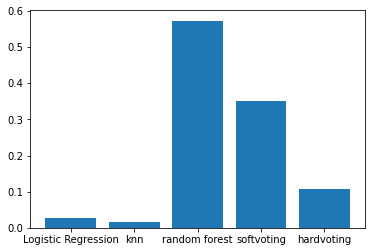

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

x=np.arange(5)
plt.bar(x, height=[lr_acc, knn_acc, rf_acc, softvoting_acc, hardvoting_acc])
plt.xticks(x,['Logistic Regression','knn', 'random forest', 'softvoting', 'hardvoting'])

soft, hard voting 에 사용된 모델들에서 acc 자체가 낮기 때문에 voting을 해도 큰 acc는 나타나지 않음.

또한 오히려 acc 차이가 많이 나는 모델들을 결합했다 보니 voting이 개별모델보다 acc가 낮아짐.

위에 acc가 낮은 lr, knn, svm을 soft voting 한 경우 세 가지 개별모델보다 voting을 실시한 acc가 높은 것을 확인할 수 있음.